In [19]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
import torch




In [20]:
# Load preprocessed data
data = pd.read_csv('../data/preprocessed_data.csv')
tester = pd.read_csv('../data/data_tester.csv')

In [21]:
# Check duplicate columns
print(data.columns)
print(tester.columns)


Index(['text', 'label', 'preprocessed_text'], dtype='object')
Index(['text', 'label', 'preprocessed_text'], dtype='object')


In [22]:
# Drop duplicate 'text' columns (assuming the second is unintended)
data = data.loc[:, ~data.columns.duplicated()]
tester = tester.loc[:, ~tester.columns.duplicated()]


In [23]:
print(data.columns)
print(tester.columns)


Index(['text', 'label', 'preprocessed_text'], dtype='object')
Index(['text', 'label', 'preprocessed_text'], dtype='object')


In [24]:
# data = data.rename(columns={'preprocessed_text': 'text'})
# tester = tester.rename(columns={'preprocessed_text': 'text'})

from datasets import Dataset

train_dataset = Dataset.from_pandas(data)
test_dataset = Dataset.from_pandas(tester)




In [25]:
# Tokenize
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding='max_length')

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)



Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [12]:
# Format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Load model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # updated parameter name
    logging_dir="./logs",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    save_strategy="epoch"
)




In [14]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)



In [15]:
# Start training
trainer.train()

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,No log,0.342307
2,No log,0.353676
3,No log,0.380526


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=189, training_loss=0.2559496763522032, metrics={'train_runtime': 2032.5538, 'train_samples_per_second': 1.476, 'train_steps_per_second': 0.093, 'total_flos': 397402195968000.0, 'train_loss': 0.2559496763522032, 'epoch': 3.0})

In [26]:
predictions = trainer.predict(test_dataset)


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [27]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

y_pred = np.argmax(predictions.predictions, axis=1)  # Convert logits to predicted class
y_true = predictions.label_ids  # Actual labels from test set


In [28]:
print(classification_report(y_true, y_pred))
print("Accuracy:", accuracy_score(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.90      0.87      0.88     12500
           1       0.87      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

Accuracy: 0.88604


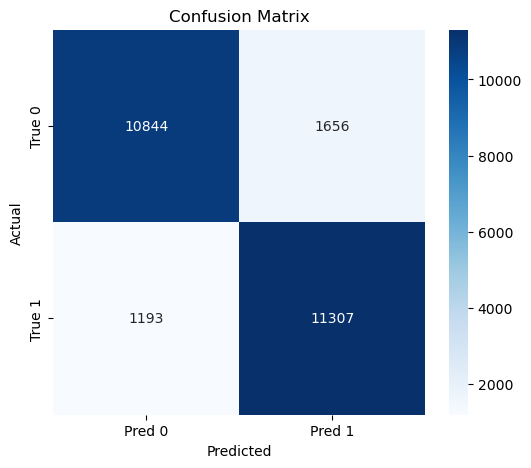

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# y_true and y_pred from previous evaluation
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [30]:
tester_copy = tester.copy()  # assuming `tester` is your original DataFrame
tester_copy['predicted_label'] = y_pred


In [31]:
inputs = tokenizer(test_text, return_tensors="pt", truncation=True, padding="max_length")
model.to("cpu")  # ✅ Move model to CPU

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()



NameError: name 'test_text' is not defined

In [32]:
test_text = "awesome and amazing movie"

inputs = tokenizer(test_text, return_tensors="pt", truncation=True, padding="max_length")
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

label_map = {0: "Negative", 1: "Positive"}
print(f"Predicted Sentiment: {label_map[predicted_class]}")


RuntimeError: Placeholder storage has not been allocated on MPS device!

In [61]:
model.save_pretrained("./models")
tokenizer.save_pretrained("./models")


('./models/tokenizer_config.json',
 './models/special_tokens_map.json',
 './models/vocab.txt',
 './models/added_tokens.json',
 './models/tokenizer.json')